# PNW0448 City of Tacoma Watershed Tool
## Created by: Lucas Nguyen 
## Modified by: Jamie Feldman
### Date: 11/4/2021

This notebook is a Python implementation of the HSPF "PWATER" and "IWATER" subroutines, which compute runoff from pervious and impervious HRUs, respectively.

## Set up comp. env.

In [1]:
from numpy import zeros, ones, sqrt, array, full, nan, argmax, int64
from math import log, exp
import pandas as pd
from pandas import Series, date_range
from pandas.tseries.offsets import Minute
import numpy
from numpy import zeros, full, tile, float64
# from numba import types
# from numba.typed import Dict
import matplotlib.pyplot as plt
import os

## Define HSPF input params

### These are constants
#### Pervious:
    AGWETP = Active groundwater evapotranspiration (fraction)
    AGWS = Initial ative groundwater storage (inches)
    BASETP = Base flow evapotranspiration (fraction)
    CEPS = Initial interception storage (inches)
    GWVS = Initial index to groundwater slope (inches)
    IFWS = Initial interflow storage (inches)
    INFEXP = Infiltration exponent
    INFILD = Ratio of maximum to mean infiltration
    LSUR = Length of surface overland flow plane (feet)
    LZS = Initial lower zone storage (inches)
    SLSUR = Slope of surface (overland flow) plane (feet/feet)
    SURS = Initial surface (overland flow) storage (inches)
    UZS = Initial upper zone storage (inches)
    FOREST = Fraction of pervious land segment covered by forest (only if snow is considered)
#### Impervious:
    LSUR = Length of surface overland flow plane (feet)
    SLSUR = Slope of surface (overland flow) plane (feet/feet)
    RETS = Initial retention storage (in)
    SURS = Initial surface (overland flow) storage (inches)
 
### These are timeseries
    AGWLI  = Active groundwater lateral inflow (optional)
    AIRTMP = Air temperature (only if snow is considered)
    IFWLI  = Interflow lateral inflow (optional)
    LGTMP  = Lower layer/groundwater layer soil temperature (only if adsorption is considered)
    LZLI   = Lower zone lateral inflow (optional)
    PACKI  = Water equivalent of ice in snowpack (only if snow is considered)
    PETINP = Input potential ET in inches (REQUIRED)
    PETMAX = Temperature below which ET will be reduced (only if snow is considered)
    PETMIN = Temperature at and below which ET will be zero (only if snow is considered)
    PREC   = Precipitation depth in inches (REQUIRED)
    RAINF  = Rainfall in inches (only if snow is considered)
    SNOCOV = Fraction of land-segment covered by pack (only if snow is considered)
    SURLI  = Surface lateral inflow (optional)
    UZLI   = Upper zone lateral inflow (optional)
    WYIELD = Water released to the land-surface by snowpack (only if snow is considered)

### These can be either constant values or timeseries (we will treat them as constants)
#### Pervious:
    AGWRC = Daily groundwater recession constant if KVARY or GWVS = 0 (/day)
    CEPSC = Interception storage capacity (inches)
    DEEPFR = Fraction of GW inflow to deep recharge
    INFILT = Infiltration capacity (inches/hour * delt60 to convert to internal units)
    INTFW  = Interflow inflow parameter
    IRC = Interflow recession parameter (/day)
    KVARY = Groundwater outflow parameter used to describe non-linear groundwater recession rate (/inches)
    LZETP = Lower zone ET parameter
    LZSN = Lower zone nominal soil moisture storage (inches)
    NSUR = Manning’s n for overland flow plane
    UZSN = Upper zone nominal storage (inches)
#### Impervious:
    NSUR = Manning’s n for overland flow plane
    RETSC = Retention storage capacity of the surface (in)

In [2]:
ui_params_per = ['AGWETP', 'AGWS', 'BASETP', 'CEPS', 'GWVS', 'IFWS', 'INFEXP', 'INFILD', 'LSUR', 'LZS', 'SLSUR', 'SURS', 'UZS']
ui_params_imp = ['LSUR', 'RETS', 'SLSUR', 'SURS']
             
ts_params = ['PETINP','PREC']

ui_ts_params_per = ['AGWRC', 'CEPSC', 'DEEPFR', 'INFILT', 'INTFW', 'IRC', 'KVARY', 'LZETP', 'LZSN', 'NSUR', 'UZSN']
ui_ts_params_imp = ['NSUR', 'RETSC']

opt_params_per = ['AGWLI', 'IFWLI', 'LZLI', 'SURLI', 'UZLI']
opt_params_imp = ['SURLI']

# PWATER subroutine

In [3]:
def _pwater_(ui, ts):
    ''' Simulate the water budget for a pervious land segment comprised of 1 acre of a single HRU.
    
    Parameters
    ----------
    ui: dictionary, contains constants including: 'errlen', 'delt' (timestep (mins)), 'steps' (number of timesteps), 
        and select HRU parameters (see above)
        
    ts: dictionary, contains timeseries variables (1-D arrays) including: 'DAYFG', 'HRFG',
        and select HRU parameters (see above)

    Returns
    -------
    SURO: 1-D numpy array, contains surface runoff timeseries (in in-acre/timestep)
'''
    errors = zeros(int(ui['errlen'])).astype(int64)

    if 'HWTFG' in ui:
        if int(ui['HWTFG']):
            errors[9] += 1
            return

    delt60 = ui['delt'] / 60.0      # simulation interval in hours
    steps  = int(ui['steps'])
    DAYFG  = ts['DAYFG'].astype(int64)
    HRFG   = ts['HRFG'].astype(int64)

    # table of coordinates for functions used to evaluate upper zone behavior
    uzra   = array([0.0, 1.25, 1.50, 1.75, 2.00, 2.10, 2.20, 2.25, 2.5, 4.0])
    intgrl = array([0.0, 1.29, 1.58, 1.92, 2.36, 2.81, 3.41, 3.8,  7.1, 3478.])

    # like MATLAB, much faster to preinitialize variables. Store in ts Dict
    AGWET  = zeros(steps)
    AGWI   = zeros(steps)
    AGWO   = zeros(steps)
    AGWS   = zeros(steps)
    BASET  = zeros(steps)
    CEPE   = zeros(steps)
    CEPS   = zeros(steps)
    GWVS   = zeros(steps)
    IFWI   = zeros(steps)
    IFWO   = zeros(steps)
    IFWS   = zeros(steps)
    IGWI   = zeros(steps)
    INFIL  = zeros(steps)
    LZET   = zeros(steps)
    LZI    = zeros(steps)
    LZS    = zeros(steps)
    PERC   = zeros(steps)
    PERO   = zeros(steps)
    PERS   = zeros(steps)
    PET    = zeros(steps)
    PETADJ = zeros(steps)
    SUPY   = zeros(steps)
    SURI   = zeros(steps)
    SURO   = zeros(steps)
    SURS   = zeros(steps)
    TAET   = zeros(steps)
    TGWS   = zeros(steps)
    UZET   = zeros(steps)
    UZI    = zeros(steps)
    UZS    = zeros(steps)
    INFFAC = ones(steps)

    irrappV = zeros(7)
    irrcep = 0.0   # ????
    #irdraw = zeros(3)

    CSNOFG = 0
    ICEFG = 0
    IFFCFG = 1
    IFRDFG = 0
    RTOPFG = 0
    UZFG = 0
    VLEFG = 0

    if 'ICEFG' in ui:
        ICEFG = int(ui['ICEFG'])

    if 'CSNOFG' in ui:
        CSNOFG = int(ui['CSNOFG'])
        IFFCFG = int(ui['IFFCFG'])
        IFRDFG = int(ui['IFRDFG'])
        RTOPFG = int(ui['RTOPFG'])
        UZFG   = int(ui['UZFG'])
        VLEFG  = int(ui['VLEFG'])

    agwetp = ui['AGWETP']
    agws   = ui['AGWS']
    basetp = ui['BASETP']
    ceps   = ui['CEPS']
    gwvs   = ui['GWVS']
    ifws   = ui['IFWS']
    infexp = ui['INFEXP']
    infild = ui['INFILD']
    lsur   = ui['LSUR']
    lzs    = ui['LZS']
    slsur  = ui['SLSUR']
    surs   = ui['SURS']
    uzs    = ui['UZS']
#     forest = ui['FOREST']

    if ICEFG:
        fzg  = ui['FZG']
        fzgl = ui['FZGL']
    
    AGWLI  = ts['AGWLI']
    AGWRC  = ts['AGWRC']
#     AIRTMP = ts['AIRTMP']
    CEPSC  = ts['CEPSC']
    DEEPFR = ts['DEEPFR']
    IFWLI  = ts['IFWLI']
    INFILT = ts['INFILT'] * delt60
    INTFW  = ts['INTFW']
    IRC    = ts['IRC']
    KVARY  = ts['KVARY']
#     LGTMP  = ts['LGTMP']
    LZETP  = ts['LZETP']
    LZLI   = ts['LZLI']
    LZSN   = ts['LZSN']
    NSUR   = ts['NSUR']
#     PACKI  = ts['PACKI']
    PETINP = ts['PETINP']
#     PETMAX = ts['PETMAX']
#     PETMIN = ts['PETMIN']
    PREC   = ts['PREC']
#     RAINF  = ts['RAINF']
#     SNOCOV = ts['SNOCOV']
    SURLI  = ts['SURLI']
    UZLI   = ts['UZLI']
    UZSN   = ts['UZSN']
#     WYIELD = ts['WYIELD']

    # initialize  variables
    kgwV = 1.0 - AGWRC**(delt60/24.0)    # groundwater recession parameter
    rlzrat = -1.0E30
    lzfrac = -1.0E30
    rparm  = -1.0E30
    if agws < 0.0:        # no gw storage is active
        agws = 0.0
    TGWS[0] = agws

    msupy = 0.0
    dec   = nan
    src   = nan
    kifw  = nan
    ifwk2 = nan
    ifwk1 = nan

    # MASTER lOOP
    for step in range(steps):
        oldmsupy = msupy

        dayfg  = int(DAYFG[step])
        hrfg   = int(HRFG[step])
        inffac = INFFAC[step]
        kgw    = kgwV[step]

        # These lines allow constant parameters to be replaced by timeseries
        lzetp  = LZETP[step]
        cepsc  = CEPSC[step]
        uzsn   = UZSN[step]
        infilt = INFILT[step]
        kvary  = KVARY[step]
        lzsn   = LZSN[step]

        # PWATRX
        petinp = PETINP[step]
        if CSNOFG:
            airtmp = AIRTMP[step]
            petmax = PETMAX[step]
            petmin = PETMIN[step]
            snocov = SNOCOV[step]
            SUPY[step] = RAINF[step] * (1.0 - snocov) + WYIELD[step]
            if hrfg:
                petadj = (1.0 - forest) * (1.0 - snocov) + forest
                if (airtmp < petmax) and (petadj > 0.5):
                    petadj = 0.5
                if airtmp < petmin:
                    petadj = 0.0
                PETADJ[step] = petadj
            PET[step] = petinp * petadj
            if ICEFG:   # calculate factor to reduce infiltration and percolation to account for frozen ground
                inffac = max(fzgl, 1.0 - fzg * PACKI[step])
        else:
            SUPY[step] = PREC[step]
            PET[step] = petinp

        # adjust inffac based on soil temperature
        if IFFCFG == 2:
            inffac = fzgl if LGTMP[step] <= 0.0 else 1.0

        # ICEPT
        ''' Simulate the interception of moisture by vegetal or other ground cover'''
        ceps = ceps + SUPY[step] + irrcep       # add to interception storage
        cepo = 0.0
        if ceps > cepsc:
            cepo = ceps - cepsc
            ceps = cepsc
        # END ICEPT

        # in PWATRX
        suri  = cepo + SURLI[step]                # surface inflow
        msupy = suri + surs + irrappV[2]
        lzrat = lzs / lzsn   # determine the current value of the lower zone storage ratio

        if msupy <= 0.0:
            surs  = 0.0
            suro  = 0.0
            ifwi  = 0.0
            infil = 0.0
            uzi   = 0.0
        else:
            # SURFAC
            ''' Distribute the water available for infiltration and runoff - units of fluxes are in./ivl'''
            ''' establish locations of sloping lines on infiltration/inflow/sur runoff
            figure.  prefix "i" refers to "infiltration" line, ibar is the mean
            infiltration capacity over the segment, internal units of infilt are inches/ivl'''

            ibar = infilt / (lzrat**infexp)
            if inffac < 1.0:
                ibar = ibar * inffac
            imax = ibar * infild   # infild is an input parameter - ratio of maximum to mean infiltration capacity
            imin = ibar - (imax - ibar)

            if dayfg or oldmsupy==0.0:
                dummy = NSUR[step] * lsur
                dec = 0.00982 * (dummy / sqrt(slsur))**0.6
                src = 1020.0  * (sqrt(slsur) / dummy)

            ratio = max(1.0001, INTFW[step] * 2.0**lzrat)
            # DISPOSE
            # DIVISN
            if msupy <= imin:       # msupy line is entirely below other line
                under = msupy
                over  = 0.0
            elif msupy > imax:      # msupy line is entirely above other line
                under = (imin + imax) * 0.5
                over = msupy - under
            else:                   # msupy  line crosses other line
                over = ((msupy - imin)**2) * 0.5 / (imax - imin)
                under = msupy - over
            # END DIVISN
            infil = under
            if over <= 0.0:
                surs = 0.0
                suro = 0.0
                ifwi = 0.0
                uzi  = 0.0
            else:  # there is potential interflow inflow and surface detention/outflow -- the is potential direct runoff
                pdro = over

                # determine how much of this potential direct runoff will be taken by the upper zone
                if UZFG:
                    # $UZINF2 -- HSPX, ARM, NPS type calculation
                    '''Compute inflow to upper zone during this interval, using "fully forward"
                        type algorithm  as used in HSPX,ARM and NPS.  Note:  although this method
                        should give results closer to those produced by HSPX, etc., its output will
                        be more sensitive to delt than that given by subroutine uzinf'''
                    uzrat = uzs / uzsn
                    if uzrat < 2.0:
                        k1 = 3.0 - uzrat
                        uzfrac = 1.0 - (uzrat * 0.5) * ((1.0/(1.0 + k1))**k1)
                    else:
                        k2 = (2.0 * uzrat) - 3.0
                        uzfrac = (1.0/(1.0 +  k2))**k2
                    uzi = pdro * uzfrac
                else:
                    # UZINF
                    ''' Compute the inflow to the upper zone during this time interval. Do this
                        using a table look-up to handle the non-analytic integral given in
                        supporting documentation.'''

                    # find the value of the integral at initial uzra
                    uzraa = uzs  / uzsn
                    kk = argmax(uzraa < uzra)-1     # uzra[kk] < uzraa <= uzra[kk+1]
                    if kk == -1:
                        kk = 8
                        errors[1] += 1   # ERRMSG1: UZRAA exceeds UZRA array bounds
                    intga = intgrl[kk] + (intgrl[kk+1] - intgrl[kk]) * (uzraa - uzra[kk]) / (uzra[kk+1] - uzra[kk])
                    intgb = (pdro / uzsn) + intga

                    kk = argmax(intgb < intgrl)-1   # intgrl[kk] <= intgb < intgrl[kk+1]
                    if kk == -1:
                         errors[2] += 1  # ERRMSG2: INTGB exceeds INTGRL array bounds
                         kk = 8

                    uzrab = uzra[kk] + (uzra[kk+1] - uzra[kk])  * (intgb - intgrl[kk]) / (intgrl[kk+1] - intgrl[kk])
                    uzi = (uzrab - uzraa) * uzsn
                    if uzi < -1.0e-3:
                        errors[7] += 1        # UZI highly negative
                    uzi = max(0.0, uzi)        # negative inflow shouldn't happen, but does for extremely small pdro

                if uzi > pdro:
                    uzi = pdro
                uzfrac = uzi / pdro

                # the prefix "ii" is used on variables on second divisn
                iimin = imin * ratio
                iimax = imax * ratio

                # DIVISN
                if msupy <= iimin:   # msupy line is entirely below other line
                    over2 = 0.0
                elif msupy > iimax: # msupy line is entirely above other line
                    over2 = msupy - (iimin + iimax) * 0.5
                else:                   # msupy  line crosses other line
                    over2 = ((msupy - iimin)**2) * 0.5 / (iimax - iimin)
                #END DIVISN

                # psur is potential surface detention/runoff
                psur = over2
                pifwi = pdro - psur # pifwi is potential interflow inflow
                ifwi  = pifwi * (1.0 - uzfrac)

                if psur <= 0.0:
                    surs = 0.0
                    suro = 0.0
                else:
                    # there will be something on or running off the surface reduce it to account for the upper zone's share
                    psur = psur * (1.0 - uzfrac)

                    # determine how much of this potential surface detention/outflow will run off in this time interval
                    suro, surs = proute(psur, RTOPFG, delt60, dec, src, surs, errors)
            # END DISPOS
        # END SURFAC

        # INTFLW  to simulate interflow, irc only daily interpolation????
        if dayfg:
            kifw  = -log(IRC[step]) / (24.0 / delt60)
            ifwk2 = 1.0 - exp(-kifw)
            ifwk1 = 1.0 - (ifwk2 / kifw)

        # surface and near-surface zones of the land segment have not  been subdivided into blocks
        inflo = ifwi  + IFWLI[step]
        value = inflo + ifws
        if value > 0.00002:
            ifwo = (ifwk1 * inflo) + (ifwk2 * ifws)
            ifws = value - ifwo
        else:
            ifwo = 0.0
            ifws = 0.0
            uzs = uzs + value     # nothing worth routing-dump back to uzs

        # UZONE
        uzrat = uzs / uzsn
        uzs   = uzs + uzi + UZLI[step] + irrappV[3]  # add inflow to uzs
        perc = 0.0
        if uzrat - lzrat > 0.01:
            # simulate percolation
            perc = 0.1 * infilt * inffac * uzsn * (uzrat - lzrat)**3
            if perc > uzs: # computed value is too high so merely empty storage
                perc = uzs
                uzs = 0.0
            else:
                uzs -= perc

        # back to pwatrx
        iperc = perc + infil + LZLI[step]   # collect inflows to lower zone and groundwater

        # LZONE
        lperc = iperc + irrappV[4]
        lzi = 0.0
        if lperc > 0.0:    #  if necessary, recalculate the fraction of infiltration + percolation to be taken by lower zone
            if abs(lzrat - rlzrat) > 0.02 or IFRDFG:    #  it is time to recalculate
                rlzrat = lzrat
                if lzrat <= 1.0:
                    indx = 2.5 - 1.5 * lzrat
                    lzfrac = 1.0 if IFRDFG  else 1.0 - lzrat  * (1.0 / (1.0 + indx))**indx
                else:
                    indx   = 1.5 * lzrat - 0.5
                    exfact = -1.0 * IFRDFG
                    lzfrac = exp(exfact * (lzrat-1.0)) if IFRDFG else (1.0 / (1.0 + indx))**indx
            lzi = lzfrac * lperc
            lzs += lzi

        # simulate groundwater behavior - first account for the fact that iperc doesn't include lzirr
        gwi = iperc + irrappV[4] - lzi

        # GWATER
        igwi = 0.0
        agwi = 0.0
        if gwi > 0.0:
            igwi  = DEEPFR[step] * gwi
            agwi = gwi - igwi
        ainflo = agwi + AGWLI[step] + irrappV[5]  # active groundwater total inflow includes lateral inflow #$3466
        agwo = 0.0

        # evaluate groundwater recharge parameter
        if kvary > 0.0:
            # update the index to variable groundwater slope
            gwvs += ainflo
            if dayfg:
                gwvs = gwvs * 0.97 if gwvs > 0.0001 else 0.0

            # groundwater outflow(baseflow)
            if agws > 1.0e-20:
                # enough water to have outflow
                agwo = kgw * (1.0 + kvary * gwvs) * agws
                avail = ainflo + agws
                if agwo > avail:
                    errors[3] += 1     # ERRMSG3: Reduced AGWO value to available
                    agwo = avail
        elif agws > 1.0e-20:
            agwo = kgw * agws  # enough water to have outflow

        if agwo < 0.0:
            agwo = 0.0

        # no remaining water - this should happen only with hwtfg=1 it may
        # happen from lateral inflows, which is a bug, in which case negative
        # values for agws should show up inthe output timeseries
        agws = agws + (ainflo - agwo)
        if agws < 0.0:
            errors[8] += 1    #ERRMSG8: Reset AGWS to zero
            agws = 0.0

        ''' # check removed - now total PERLND agreement with HSPF
        if abs(kvary) > 0.0 and gwvs > agws:
            errors[4] += 1  # ERRMSG4: Reduced GWVS to AGWS
            gwvs = agws
        '''

        # back in #$PWATRX
        TGWS[step] = agws

        # EVAPT to simulate evapotranspiration
        rempet = PET[step]  # rempet is remaining potential et - inches/ivl
        taet  = 0.0  # taet is total actual et - inches/ivlc
        baset = 0.0
        if rempet > 0.0 and basetp > 0.0:
            # in section #$etbase  there is et from baseflow
            baspet = basetp * rempet
            if baspet > agwo:
                baset = agwo
                agwo  = 0.0
            else:
                baset = baspet
                agwo -= baset
            taet   += baset
            rempet -= baset

        cepe  = 0.0
        if rempet > 0.0 and ceps > 0.0:
            # EVICEP
            if rempet > ceps:
                cepe = ceps
                ceps = 0.0
            else:
                cepe  = rempet
                ceps -= cepe
            taet   += cepe
            rempet -= cepe

        uzet  = 0.0
        if rempet > 0.0:
            # ETUZON
            # ETUZS
            if uzs > 0.001:  # there is et from the upper zone estimate the uzet opportunity
                uzrat = uzs / uzsn
                uzpet = rempet  if uzrat > 2.0  else  0.5 * uzrat * rempet
                if uzpet > uzs:
                    uzet = uzs
                    uzs  = 0.0
                else:
                    uzet = uzpet
                    uzs -= uzet
            # END UTUZA
            taet   += uzet    # these lines return to ETUZON
            rempet -= uzet
            # END ETUZON

        agwet = 0.0
        if rempet > 0.0 and agwetp > 0.0:
            # ETAGW et from groundwater determine remaining capacity
            gwpet = rempet * agwetp
            if gwpet > agws:
                agwet = agws
                agws  = 0.0
            else:
                agwet = gwpet
                agws -= agwet

            if abs(kvary) > 0.0:
                gwvs -= agwet   # update variable storage
                if gwvs < -0.02:
                    errors[5] += 1.0   # ERRMSG5: GWVS < -0.02, set to zero
                    gwvs = 0.0
            taet   += agwet
            rempet -= agwet

        # et from lower zone is handled here because it must be called every interval to make sure that seasonal variation in
        # parameter lzetp and recalculation of rparm are correctly done ; simulate et from the lower zone
        # note: thj made changes in some release to the original HSPF, check carefully
        # ETLZON
        if dayfg:
            lzrat = lzs / lzsn  # it is time to recalculate et opportunity parameter rparm is max et opportunity - inches/ivl
            rparm = 0.25/(1.0-lzetp)*lzrat*delt60/24.0 if lzetp <= 0.99999 else 1.0e10
        lzet  = 0.0
        if rempet > 0.0 and lzs > 0.02:     # assume et can take place
            if lzetp >= 0.99999:      # special case - will try to draw et from whole land segment at remaining potential rate
                lzpet = rempet * lzetp
            elif VLEFG <= 1:   # usual case - desired et will vary over the whole land seg
                lzpet = 0.5*rparm if rempet > rparm else rempet*(1.0-rempet/(2.0*rparm))
                if lzetp < 0.5:
                    lzpet = lzpet * 2.0 * lzetp # reduce the et to account for area devoid of vegetation
            else:    #  VLEFG >= 2:   # et constant over whole land seg
                lzpet = lzetp*lzrat*rempet if lzrat < 1.0 else lzetp*rempet
            lzet = lzpet if lzpet < (lzs - 0.02) else lzs - 0.02
            lzs    -= lzet
            taet   += lzet
            rempet -= lzet
        # END ETLZON
        # END EVAPT

        # back in PWATRX
        TGWS[step] = agws

        # return to PWATRX
        AGWET[step] = agwet
        AGWI[step]  = agwi
        AGWO[step]  = agwo
        AGWS[step]  = agws
        BASET[step] = baset
        CEPE[step]  = cepe
        CEPS[step]  = ceps
        GWVS[step]  = gwvs
        IFWI[step]  = ifwi
        IFWO[step]  = ifwo
        IFWS[step]  = ifws
        IGWI[step]  = igwi
        INFFAC[step]= inffac
        INFIL[step] = infil
        LZET[step]  = lzet
        LZI[step]   = lzi
        LZS[step]   = lzs
        PERC[step]  = perc
        PERO[step]  = suro + ifwo + agwo
        PERS[step]  = ceps + surs + ifws + uzs + lzs + TGWS[step]
        SURI[step]  = suri
        SURO[step]  = suro
        SURS[step]  = surs
        TAET[step]  = taet
        UZET[step]  = uzet
        UZI[step]   = uzi
        UZS[step]   = uzs
    # done with MASTER step
    #WATIN  = SUPY + SURLI + UZLI + IFWLI + LZLI + AGWLI+ irrapp[6]   # total input of water to the pervious land segment
    #WATDIF = WATIN - (PERO + IGWI + TAET + irdraw[2])                # net input of water to the pervious land segment
    
    return SURO # IFWO # SURO # AGWO 
# TODO: make default output all params but allow specify

In [4]:
def proute(psur, RTOPFG, delt60, dec, src, surs, errors):
    ''' Determine how much potential surface detention (PSUR) runs off in one simulation interval.'''
    if psur > 0.0002:
        # something is worth routing on the surface
        if RTOPFG != 1:
            # do routing the new way, estimate the rate of supply to the overland flow surface - inches/hour
            ssupr = (psur - surs) / delt60
            surse = dec * ssupr**0.6 if ssupr > 0.0 else 0.0         # determine equilibrium depth for this supply rate

            # determine runoff by iteration - newton's method,  estimate the new surface storage
            sursnw = psur
            suro    = 0.0
            for count in range(MAXLOOPS):
                if ssupr > 0.0:
                    ratio = sursnw / surse
                    fact = 1.0 + 0.6 * ratio**3 if ratio <= 1.0 else 1.6
                else:
                    ratio =  1.0e30
                    fact  = 1.6

                # coefficient in outflow equation
                ffact  = (delt60 * src * fact**1.667) * (sursnw**1.667)
                fsuro  = ffact - suro
                dfact  = -1.667 * ffact

                dfsuro = dfact / sursnw - 1.0
                if ratio <= 1.0:       #  additional term required in derivative wrt suro
                    dterm  = dfact / (fact * surse) * 1.8 * ratio**2
                    dfsuro = dfsuro + dterm
                dsuro = fsuro / dfsuro

                suro  = suro - dsuro
                if suro <= 1.0e-10:    # boundary condition- don't let suro go negative
                    suro = 0.0

                sursnw = psur - suro
                change = 0.0
                if abs(suro) > 0.0:
                    change = abs(dsuro / suro)
                if change < 0.01:
                    break
            else:
                errors[6] += 1        # ERRMSG6: Proute runoff did not converge
            surs = sursnw
        else:
            # do routing the way it is done in arm, nps, and hspx estimate the rate of supply to the overland flow surface - inches/ivl
            ssupr = psur - surs
            sursm = (surs + psur) * 0.5  # estimate the mean surface detention

            # estimate the equilibrium detention depth for this supply rate - surse
            if ssupr > 0.0:
                # preliminary estimate of surse
                dummy = dec * ssupr**0.6
                if dummy > sursm:
                    surse = dummy              # flow is increasing
                    dummy = sursm * (1.0 + 0.6 * (sursm/surse)**3)
                else:
                    dummy = sursm * 1.6  # flow on surface is at equilibrium or receding
            else:
                dummy = sursm * 1.6  # flow on the surface is receding - equilibrium detention is assumed equal to actual detention

            # check the temporary calculation of surface outflow
            tsuro = delt60 * src * dummy**1.667
            suro  = psur  if tsuro > psur  else tsuro
            surs  = 0.0   if tsuro > psur  else psur - suro
    else:
        # send what is on the overland flow plane straight to the channel
        suro = psur
        surs = 0.0
    if suro <= 1.0e-10:
        suro = 0.0     # fix bug in on pc - underflow leads to "not a number"

    return suro, surs

# IWATER subroutine

In [5]:
def _iwater_(ui, ts):
    ''' Simulate the water budget for an impervious land segment comprised of 1 acre of a single HRU.
    
    Parameters
    ----------
    ui: dictionary, contains constants including: 'errlen', 'delt' (timestep (mins)), 'steps' (number of timesteps), 
        and select HRU parameters (see above)
        
    ts: dictionary, contains timeseries variables (1-D arrays) including: 'HR1FG', 'HRFG',
        and select HRU parameters (see above)

    Returns
    -------
    SURO: 1-D numpy array, contains surface runoff timeseries (in in-acre/timestep)
'''
    errors = zeros(int(ui['errlen'])).astype(int64)

    if 'HWTFG' in ui:
        if int(ui['HWTFG']):
            errors[9] += 1
            return
        
    # get simulation timestep and duration information from ui and ts
    delt60 = ui['delt'] / 60.0      # simulation interval in hours
    steps  = int(ui['steps'])
    HRFG   = ts['HRFG'].astype(int64) # True the first time and at every hour of simulation
    HR1FG  = ts['HR1FG'].astype(int64) # True the first time and at 1am every day of simulation. 
#     TODO: look into why HR1FG not DAYFG

    # like MATLAB, much faster to preinitialize variables. Store in ts Dict
    IMPEV  = zeros(steps, dtype=float64) # evaporation from retention storage
    PET    = zeros(steps) # potential ET
    PETADJ = zeros(steps) # adjustment factor for potential ET
    RETS   = zeros(steps) # retention storage
    SUPY   = zeros(steps) # water supply to 
    SURI   = zeros(steps)
    SURO   = zeros(steps)
    SURS   = zeros(steps)

    # get constant surface parameters from ui
    lsur   = ui['LSUR'] # length of flow path
    slsur  = ui['SLSUR'] # slope of land surface
    rets = ui['RETS'] # initial retention storage
    surs = ui['SURS'] # initial surface overland storage
    
    # set flag values
    RTLIFG = 0 # flag to retain lateral surface inflow
    if 'RTLIFG' in ui:
        RTLIFG = int(ui['RTLIFG'])
    CSNOFG = 0 # flag to consider snow
    if 'CSNOFG' in ui:
        CSNOFG = int(ui['CSNOFG'])
    RTOPFG = 0 # flag to select the algorithm for computing overland flow
    if 'RTOPFG' in ui:
        RTOPFG = int(ui['RTOPFG'])
    
    # get timeseries parameters from ts
    RETSC  = ts['RETSC'] # retention capacity of surface
    NSUR   = ts['NSUR'] # Manning's N
    PETINP = ts['PETINP'] # evap
    PREC   = ts['PREC'] # precip
    SURLI  = ts['SURLI'] # surface lateral inflow
#     AIRTMP = ts['AIRTMP']
#     PETMAX = ts['PETMAX']
#     PETMIN = ts['PETMIN']
#     SNOCOV = ts['SNOCOV']
#     RAINF  = ts['RAINF']
#     WYIELD = ts['WYIELD']

    # initialize other variables
    msupy = surs # initial moisture supply = initial surface storage
    dec   = nan 
    src   = nan
    surse = nan
    ssupr = nan
    dummy = nan
    d     = nan
    supy  = 0.0 # moisture applied to land segment

    # MASTER lOOP
    for step in range(steps):
        oldmsupy = msupy # store original moisture supply value

        hr1fg  = int(HR1FG[step]) # set timestep flags
        hrfg   = int(HRFG[step])
        
        # IWATRX
        petinp = PETINP[step] # set potential evap
        retsc = RETSC[step] # set retention capacity
        if CSNOFG: # snow is not considered, so evaluates as False. Skip to else
            airtmp = AIRTMP[step]
            petmax = PETMAX[step]
            petmin = PETMIN[step]
            snocov = SNOCOV[step]
            SUPY[step] = RAINF[step] * (1.0 - snocov) + WYIELD[step]
            if hrfg:
                petadj = 1.0 - snocov
                if airtmp < petmax: 
                    if petadj > 0.5:
                        petadj = 0.5
                    if airtmp < petmin:
                        petadj = 0.0
                PETADJ[step] = petadj
            PET[step] = petinp * petadj
        else:
            supy = PREC[step] # snow not considered, so moisture supply = rainfall
            pet  = petinp 
        PET[step]  = pet # record evap in timeseries
        SUPY[step] = supy # record supply in timeseries

        surli  = SURLI[step] # set surface lateral inflow
        retsc = RETSC[step] # set retention capacity
        
        if RTLIFG: # no lateral surface inflow (and no retention thereof), so evaluates as False. Skip to else
            reti = supy + surli

            # RETN
            rets += reti
            if rets > retsc:
                reto = rets - retsc
                rets = retsc
            else:
                reto = 0.0
            suri = reto
        else:
            reti = supy # inflow to impervious retention storage = moisture supply = precipitation

            # RETN
            rets += reti # add the retention storage inflow to the impervious retention storage
            if rets > retsc: # if the retention storage is greater than the parameter value  (often evaluates as True)
                reto = rets - retsc # send the difference out as outflow from retention storage 
                rets = retsc # leave the rest in retention storage
            else:
                reto = 0.0
            suri = reto + surli # no surface lateral inflow, so surface detention inflow = outflow from retention storage
        # IWATER
        msupy = suri + surs # no intial surface detention storage, so water supply = surface detention inflow
        
        suro = 0.0  
        if msupy > 0.0002: # initial water supply is 0, so skip all of this
            if RTOPFG: 
                # IROUTE for RTOPFG==True, the way it is done in arm, nps, and hspx
                if oldmsupy == 0.0 or hr1fg:   # Time to recompute
                    dummy  = NSUR[step] * lsur
                    dec = 0.00982 * (dummy/sqrt(slsur))**0.6
                    src = 1020.0 * sqrt(slsur)/dummy

                sursm = (surs + msupy) * 0.5
                dummy = sursm * 1.6
                if suri > 0.0:
                    d = dec*suri**0.6
                    if d > sursm:
                        surse = d
                        dummy = sursm * (1.0 + 0.6 * (sursm / surse)**3)
                tsuro = delt60 * src * dummy**1.67
                suro  = msupy if tsuro > msupy else tsuro
                surs  = 0.0   if tsuro > msupy else msupy - suro
            else:
                # IROUTE for RTOPFG==False
                if oldmsupy == 0.0 or hr1fg:   # Time to recompute
                    dummy = NSUR[step] * lsur
                    dec = 0.00982 * (dummy/sqrt(slsur))**0.6
                    src = 1020.0 * sqrt(slsur)/dummy
                ssupr  = suri / delt60
                surse  = dec * ssupr**0.6 if ssupr > 0.0 else 0.0
                sursnw = msupy
                suro   = 0.0

                for count in range(MAXLOOPS):
                    if ssupr > 0.0:
                        ratio = sursnw / surse
                        fact = 1.0 + 0.6 * ratio**3  if ratio <= 1.0 else 1.6
                    else:
                        fact  = 1.6
                        ratio = 1e30

                    ffact  = (delt60 * src * fact**1.667) * (sursnw**1.667)
                    fsuro  = ffact - suro
                    dfact  = -1.667 * ffact

                    dfsuro = dfact/sursnw - 1.0
                    if ratio <= 1.0:
                        dfsuro += (dfact/(fact * surse)) * 1.8 * ratio**2
                    dsuro = fsuro / dfsuro

                    suro = suro - dsuro
                    sursnw = msupy - suro

                    if abs(dsuro / suro) < TOLERANCE:
                        break
                else:
                    errors[0] = errors[0] + 1  # IROUTE did not converge
                surs = sursnw
        else:
            suro = msupy
            surs = 0.0

        # EVRETN
        if rets > 0.0:
            if pet > rets:
                impev = rets
                rets  = 0.0
            else:
                impev = pet
                rets -= impev
        else:
            impev = 0.0
        IMPEV[step] = impev

        # return to IWATRX
        RETS[step]  = rets
        SURI[step]  = suri
        SURO[step]  = suro
        SURS[step]  = surs

    # done with MASTER step
    return SURO 
# TODO: make default output all params but allow specify

In [6]:
def initm(siminfo, ui, flag, monthly, default):
    ''' initialize timeseries with HSPF interpolation of monthly array or with fixed value'''
    if flag and monthly in ui:
        month = ui[monthly].values()
        return dayval(siminfo, list(month))
    else:
        return full(siminfo['steps'], default)
    
    
def hourflag(siminfo, hourfg, dofirst=False):
    '''timeseries with 1 at desired hour and zero otherwise'''
    hours24 = zeros(24)
    hours24[hourfg] = 1.0
    return hoursval(siminfo, hours24, dofirst)


def hoursval(siminfo, hours24, dofirst=False, lapselike=False):
    '''create hours flags, flag on the hour or lapse table over full simulation'''
    start = siminfo['start']
    stop  = siminfo['stop']
    freq  = Minute(siminfo['delt'])

    dr = date_range(start=f'{start.year}-01-01', end=f'{stop.year}-12-31', freq=Minute(60))
    hours = tile(hours24, (len(dr) + 23) // 24).astype(float)
    if dofirst:
        hours[0] = 1

    ts = Series(hours[0:len(dr)], dr)
    if lapselike:
        if ts.index.freq > freq:     # upsample
            ts = ts.resample(freq).asfreq().ffill()
        elif ts.index.freq < freq:   # downsample
            ts = ts.resample(freq).mean()
    else:
        if ts.index.freq > freq:     # upsample
            ts = ts.resample(freq).asfreq().fillna(0.0)
        elif ts.index.freq < freq:   # downsample
            ts = ts.resample(freq).max()
    return ts.truncate(start, stop).to_numpy()

# Compare to WWHM

## Define simulation period

In [7]:
# siminfo = {'start':pd.to_datetime('2000-10-01'), 'stop':pd.to_datetime('2005-09-30'), 'delt':15}
# steps = (siminfo['stop']-siminfo['start']).days*(1440/siminfo['delt'])
# siminfo['steps'] = int(steps)
# siminfo

## Prep Precip and ET

In [8]:
# wwhm_precip = (pd.read_csv('timeseries\WWHM\Precip_40inEast_15min.txt', sep = '\s+')
#                .assign(Year = lambda df: df['Date'].str[:4])
#                .assign(Month = lambda df: df['Date'].str[5:7])
#                .assign(Day = lambda df: df['Date'].str[8:10])
#                .assign(DateTime = lambda df: pd.to_datetime(df['Month']+'/'+df['Day']+'/'+df['Year']+' '+df['Time']))
#                .set_index('DateTime')
#                .loc[siminfo['start']:siminfo['stop']]
#                [['2-in']]
#                .to_numpy().flatten()
#               )

In [9]:
# len(wwhm_precip)

In [10]:
# et_factor = 1
# wwhm_evap = (pd.read_csv('timeseries\WWHM\Evap_40inEast_24hr.txt', sep = '\s+')
#                 .assign(Year = lambda df: df['Date'].str[:4])
#                 .assign(Month = lambda df: df['Date'].str[5:7])
#                 .assign(Day = lambda df: df['Date'].str[8:10])
#                 .assign(DateTime = lambda df: pd.to_datetime(df['Month']+'/'+df['Day']+'/'+df['Year']+' '+df['Time']))
#                 .set_index('DateTime')
#                 [['1-in']]
#                 .resample('15min').ffill() #Convert from 24hr to 15min record 
#                 .loc[siminfo['start']:siminfo['stop']]
#                 .to_numpy().flatten()/(1440/15)*et_factor #Convert from units of in/day to in/15min and apply et factor
#             )

In [11]:
# len(wwhm_evap)

In [12]:
# wwhm_ts = {'PREC':wwhm_precip, 'PETINP':wwhm_evap}
# wwhm_ts

## Define HRU params

In [13]:
# wwhm_params_per = pd.read_csv('wwhm\WWHM_PERLNDs.csv', index_col=0)
# wwhm_params_per.head()

In [14]:
# wwhm_params_imp = pd.read_csv('wwhm\WWHM_IMPLNDS.csv', index_col=0)
# wwhm_params_imp.head()

## Run model

In [15]:
# MAXLOOPS  = 100      # newton method max loops
# TOLERANCE = 0.01     # newton method exit tolerance
# CONV_FACTOR = (1/12)*43560*(1/(15*60)) # convert from in-acre/timestep to cfs

# hspLite_suro = {}

# hrus = ['Roads/Steep']
# hru_cat = 'imp'

# for hru in hrus:
#     hru_str = hru.replace('/','').replace(', ','')
    
#     ui = {}
#     ui['errlen'] = 10 # errlen sets the length of the error array, which is indexed up to 9, so let's just set to 10
#     ui['delt'] = siminfo['delt'] 
#     ui['steps'] = siminfo['steps'] 
    
#     ts = {}
#     ts['DAYFG'] = hourflag(siminfo, 0, dofirst = True)  # true the first time and at start of every day of simulation
#     ts['HRFG'] = hoursval(siminfo, ones(24), dofirst=True) # true the first time and at every hour of simulation
#     ts['HR1FG'] = hourflag(siminfo, 1, dofirst=True) # true the first time and at 1am every day of simulation
    
#     for param in ts_params:
#         ts[param] = wwhm_ts[param]
    
#     if hru_cat == 'per':
#         for param in ui_params_per:
#             ui[param] = wwhm_params_per.loc[hru][param]
#         for param in ui_ts_params_per:
#             ts[param] = numpy.full(siminfo['steps'], wwhm_params_per.loc[hru][param])
#         for param in opt_params_per:
#             ts[param] = numpy.zeros(siminfo['steps'])
            
#         hru_suro = _pwater_(ui, ts) * CONV_FACTOR # convert from in-acre/timestep to cfs 
    
#     if hru_cat == 'imp':
#         for param in ui_params_imp:
#             ui[param] = wwhm_params_imp.loc[hru][param]
#         for param in ui_ts_params_imp:
#             ts[param] = numpy.full(siminfo['steps'], wwhm_params_imp.loc[hru][param])
#         for param in opt_params_imp:
#             ts[param] = numpy.zeros(siminfo['steps'])
        
#         hru_suro = _iwater_(ui, ts) * CONV_FACTOR # convert from in-acre/timestep to cfs
        
#     hspLite_suro[hru_str] = hru_suro
    
#     hru_df = pd.DataFrame(hru_suro, columns = [hru_str+'_cfs'], 
#                           index = pd.date_range(start=siminfo['start'], periods=siminfo['steps'], freq='15min'))
#     hru_df.to_csv('timeseries\hspLite\SURO_'+hru_str+'.csv')

## Compare results

In [16]:
# wwhm_suro = (pd.read_csv('timeseries\WWHM\SurfaceFlow_10ac_RoadsSteep_15min.txt', sep = '\s+')
#                 .assign(Year = lambda df: df['Date'].str[:4])
#                 .assign(Month = lambda df: df['Date'].str[5:7])
#                 .assign(Day = lambda df: df['Date'].str[8:10])
#                 .assign(DateTime = lambda df: pd.to_datetime(df['Month']+'/'+df['Day']+'/'+df['Year']+' '+df['Time']))
#                 .set_index('DateTime').sort_index()
#                 .loc[siminfo['start']:siminfo['stop']]
#                 [['501-cfs']]
#                 .rename(columns = {'501-cfs':'WWHM_RoadsSteep_cfs'})
#             )
# wwhm_suro.head()

In [17]:
# acres = 10
# _hspLite_suro = pd.read_csv('timeseries\hspLite\SURO_RoadsSteep.csv', index_col = 0, parse_dates = True)*acres
# _hspLite_suro.head()

In [18]:
# _hspLite_suro.sum()

In [19]:
# compare_df = (wwhm_suro
#               .join(_hspLite_suro)
#               .join(pd.DataFrame(wwhm_precip, columns = ['Precip_in'],
#                 index = pd.date_range(start=siminfo['start'], periods=siminfo['steps']+1, freq='15min')))
#               .assign(Diff = lambda df: df['WWHM_RoadsSteep_cfs'] - df['RoadsSteep_cfs'])
#              )
# compare_df.head()

In [20]:
# compare_df.to_csv('timeseries\SURO_RoadsSteep_Comparison.csv')

In [21]:
# fig = plt.figure(figsize = (16,8))
# ax = fig.add_subplot(211)
# ax.plot(compare_df['WWHM_RoadsSteep_cfs'], label = 'WWHM') #.resample('D').mean()
# ax.plot(compare_df['RoadsSteep_cfs'], label = 'hspLite') #.resample('D').mean()
# ax.legend()
# ax.set_xlabel('Simulation Period')
# ax.set_ylabel('Surface Flow (cfs)')
# ax.set_title('Flow From ' + str(acres) + ' Acres of HRU: Roads, Steep')

# ax2 = fig.add_subplot(212)
# ax2.plot(compare_df['Diff'])
# ax2.set_xlabel('Simulation Period')
# ax2.set_ylabel('Difference (cfs)')
# ax2.set_title('Difference between WWHM and hspLite')

# fig.subplots_adjust(hspace = 0.3)
# fig.savefig('timeseries\SURO_RoadsSteep_Comparison.png')

# Compare to Previous

## Define simulation period

In [146]:
siminfo = {'start':pd.to_datetime('1980-01-01'), 'stop':pd.to_datetime('2000-12-31'), 'delt':60}
steps = (siminfo['stop']-siminfo['start']).days*(1440/siminfo['delt'])
siminfo['steps'] = int(steps)
siminfo

{'start': Timestamp('1980-01-01 00:00:00'),
 'stop': Timestamp('2000-12-31 00:00:00'),
 'delt': 60,
 'steps': 184080}

## Prep Precip and ET

In [147]:
precip = (pd.read_csv('timeseries\compare_to_prev\CIG_GFDL_tacoma_precip_mm.csv')
               .assign(DateTime = lambda df: pd.to_datetime('1970-01-01')+pd.to_timedelta(df['times'], unit = 'hour'))
               .set_index('DateTime')
               .loc[siminfo['start']:siminfo['stop']]
                .resample('1h').asfreq().fillna(0) #fill leap days with 0 since not in timeseries
               [['PREC']]
               .to_numpy().flatten()*0.0393701 #convert to inches
              )

C:\Users\jfeldman\miniconda3\envs\hspf\lib\site-packages\IPython\core\interactiveshell.py:3444: DtypeWarning: Columns (2) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [148]:
len(precip)

184081

In [156]:
et_factor = 1
# evap = pd.read_csv('timeseries\compare_to_prev\Terraclimate_potential_evapotranspiration.csv')
# evap = (evap.append({'Time':'31-Dec-00','pet (mm)': evap.iloc[-1]['pet (mm)']}, ignore_index = True)
#                 .assign(DateTime = lambda df: pd.to_datetime(df['Time']))
#                 .assign(Days = lambda df: df['DateTime'].dt.days_in_month)
#                 .assign(PET_per_hr = lambda df: df['pet (mm)'].astype(int)/df['Days']/24)
#                 .set_index('DateTime')
#                 .resample('1h').ffill()
#                 .loc[siminfo['start']:siminfo['stop']]
#                 [['PET_per_hr']]
#                 .to_numpy().flatten()*et_factor*0.0393701 #convert to inches
#             )

_wwhm_evap = (pd.read_csv('timeseries\compare_to_prev\Evap_wwhm_40inEast_24hr.txt', sep = '\s+')
                .assign(Month = lambda df: df['Date'].str[5:7])
                .groupby('Month').mean()
             )
wwhm_evap = (pd.concat([_wwhm_evap]*22, ignore_index = True)
                [['1-in']]
                 .assign(datetime = pd.date_range(start=siminfo['start']-pd.Timedelta(days=365), periods=12*22, freq='M'))
                 .set_index('datetime')
                .resample('1D').bfill() #Convert from monthly to daily frequency
                 .resample('1h').ffill() #Convert from daily to hourly frequency
                .loc[siminfo['start']:siminfo['stop']]#*25.4
                .to_numpy().flatten()/(1440/60)*et_factor #Convert from units of in/day to in/hr and apply et factor
            )

In [157]:
# wwhm_evap.to_csv('timeseries\compare_to_prev\Check_WWHM_Evap_mm_per_day.csv')

In [158]:
len(wwhm_evap)

184081

In [159]:
test_ts = {'PREC':precip, 'PETINP':wwhm_evap}
test_ts

{'PREC': array([0.00459927, 0.00067763, 0.00029316, ..., 0.        , 0.        ,
        0.        ]),
 'PETINP': array([0.00112201, 0.00112201, 0.00112201, ..., 0.00079175, 0.00079175,
        0.00079175])}

## Define HRU params

In [160]:
wwhm_params_imp = pd.read_csv('wwhm\WWHM_IMPLNDS.csv', index_col=0)
wwhm_params_imp

,USER,IN,OUT,ENGL,METER,ATMP,SNOW,IWAT,SLD,IWG,...,VNN,RTLI,LSUR,SLSUR,NSUR,RETSC,PETMAX,PETMIN,RETS,SURS
Roads/Flat,1,1,1,27,0,0,0,1,0,0,...,0,0,400,0.01,0.1,0.10,0,0,0,0
Roads/Mod,1,1,1,27,0,0,0,1,0,0,...,0,0,400,0.05,0.1,0.08,0,0,0,0
Roads/Steep,1,1,1,27,0,0,0,1,0,0,...,0,0,400,0.10,0.1,0.05,0,0,0,0
Roof Tops/Flat,1,1,1,27,0,0,0,1,0,0,...,0,0,400,0.01,0.1,0.10,0,0,0,0
Driveways/Flat,1,1,1,27,0,0,0,1,0,0,...,0,0,400,0.01,0.1,0.10,0,0,0,0
Driveways/Mod,1,1,1,27,0,0,0,1,0,0,...,0,0,400,0.05,0.1,0.08,0,0,0,0
Driveways/Steep,1,1,1,27,0,0,0,1,0,0,...,0,0,400,0.10,0.1,0.05,0,0,0,0
Sidewalks/Flat,1,1,1,27,0,0,0,1,0,0,...,0,0,400,0.01,0.1,0.10,0,0,0,0
Sidewalks/Mod,1,1,1,27,0,0,0,1,0,0,...,0,0,400,0.05,0.1,0.08,0,0,0,0
Sidewalks/Steep,1,1,1,27,0,0,0,1,0,0,...,0,0,400,0.10,0.1,0.05,0,0,0,0


In [161]:
wwhm_params_per = pd.read_csv('wwhm\WWHM_PERLNDS.csv', index_col=0)
wwhm_params_per

,NBLKS,USER,IN,OUT,ENGL,METER,ATMP,SNOW,PWAT,SED,...,DELTA,UELFAC,LELFAC,CEPS,SURS,UZS,IFWS,LZS,AGWS,GWVS
"A/B, Forest, Flat",1,1,1,1,27,0,0,0,1,0,...,0.2,4,2.5,0,0,0,0,3.0,1,0
"A/B, Forest, Mod",1,1,1,1,27,0,0,0,1,0,...,0.2,4,2.5,0,0,0,0,3.0,1,0
"A/B, Forest, Steep",1,1,1,1,27,0,0,0,1,0,...,0.2,4,2.5,0,0,0,0,3.0,1,0
"A/B, Pasture, Flat",1,1,1,1,27,0,0,0,1,0,...,0.2,4,2.5,0,0,0,0,3.0,1,0
"A/B, Pasture, Mod",1,1,1,1,27,0,0,0,1,0,...,0.2,4,2.5,0,0,0,0,3.0,1,0
"A/B, Pasture, Steep",1,1,1,1,27,0,0,0,1,0,...,0.2,4,2.5,0,0,0,0,3.0,1,0
"A/B, Lawn, Flat",1,1,1,1,27,0,0,0,1,0,...,0.2,4,2.5,0,0,0,0,3.0,1,0
"A/B, Lawn, Mod",1,1,1,1,27,0,0,0,1,0,...,0.2,4,2.5,0,0,0,0,3.0,1,0
"A/B, Lawn, Steep",1,1,1,1,27,0,0,0,1,0,...,0.2,4,2.5,0,0,0,0,3.0,1,0
"C, Forest, Flat",1,1,1,1,27,0,0,0,1,0,...,0.2,4,2.5,0,0,0,0,2.5,1,0


## Run model

In [162]:
MAXLOOPS  = 100      # newton method max loops
TOLERANCE = 0.01     # newton method exit tolerance
CONV_FACTOR = 25.4 # convert from in/timestep to mm/timestep #(1/12)*43560*(1/(15*60)) # convert from in-acre/timestep/acre to cfs/acre

hspLite_suro = {}

hrus = ['Roads/Flat','A/B, Pasture, Flat']
hru_cats = ['imp','per']
i = 0

for hru in hrus:
    hru_cat = hru_cats[i]
    i = i + 1
    hru_str = hru.replace('/','').replace(', ','')
    
    ui = {}
    ui['errlen'] = 10 # errlen sets the length of the error array, which is indexed up to 9, so let's just set to 10
    ui['delt'] = siminfo['delt'] 
    ui['steps'] = siminfo['steps'] 
    
    ts = {}
    ts['DAYFG'] = hourflag(siminfo, 0, dofirst = True)  # true the first time and at start of every day of simulation
    ts['HRFG'] = hoursval(siminfo, ones(24), dofirst=True) # true the first time and at every hour of simulation
    ts['HR1FG'] = hourflag(siminfo, 1, dofirst=True) # true the first time and at 1am every day of simulation
    
    for param in ts_params:
        ts[param] = test_ts[param]
    
    if hru_cat == 'per':
        for param in ui_params_per:
            ui[param] = wwhm_params_per.loc[hru][param]
        for param in ui_ts_params_per:
            ts[param] = numpy.full(siminfo['steps'], wwhm_params_per.loc[hru][param])
        for param in opt_params_per:
            ts[param] = numpy.zeros(siminfo['steps'])
            
        hru_suro = _pwater_(ui, ts) * CONV_FACTOR # convert from in/timestep to mm/timestep # convert from in-acre/timestep/acre to cfs/acre
    
    if hru_cat == 'imp':
        for param in ui_params_imp:
            ui[param] = wwhm_params_imp.loc[hru][param]
        for param in ui_ts_params_imp:
            ts[param] = numpy.full(siminfo['steps'], wwhm_params_imp.loc[hru][param])
        for param in opt_params_imp:
            ts[param] = numpy.zeros(siminfo['steps'])
        
        hru_suro = _iwater_(ui, ts) * CONV_FACTOR # convert from in/timestep to mm/timestep # convert from in-acre/timestep/acre to cfs/acre
        
    hspLite_suro[hru_str] = hru_suro
    
    hru_df = pd.DataFrame(hru_suro, columns = [hru_str+'_mm'],#+'_cfs'], 
                          index = pd.date_range(start=siminfo['start'], periods=siminfo['steps'], freq='60min'))
    hru_df.to_csv('timeseries\compare_to_prev\hspLite_results\SURO_'+hru_str+'.csv')

## Compare results

Previous model results: hru contains a three-digit encoding as described below:

First digit: Hydrologic Soil Group Number (0 = A/B, 1 = C, 2 = Saturated)
Second digit: Land cover (0=Forest, 1=Pasture, 2=Lawn, 5=Impervious)
Third Digit: Slope (0=Flat, 1=Mod, 2=Steep)

In [168]:
prev_hru = 'hru010'#'hru250'
new_hru = 'ABPastureFlat'#'RoadsFlat' 

In [169]:
prev_suro = (pd.read_csv(os.path.join('timeseries\compare_to_prev\previous_results','15V5_'+prev_hru+'_suro.csv'), parse_dates = ['datetime'])
             .assign(datetime = lambda df: df['datetime'].dt.tz_localize(None))
             .set_index('datetime')
             .loc[siminfo['start']:siminfo['stop']]
             .rename(columns = {prev_hru:prev_hru+'_mm'})
            )
prev_suro

,hru010_mm
datetime,
1980-01-01 00:00:00,0.000000e+00
1980-01-01 01:00:00,3.060000e-08
1980-01-01 02:00:00,0.000000e+00
1980-01-01 03:00:00,0.000000e+00
1980-01-01 04:00:00,0.000000e+00
...,...
1990-12-21 07:00:00,0.000000e+00
1990-12-21 08:00:00,0.000000e+00
1990-12-21 09:00:00,0.000000e+00


In [170]:
hsp_suro = pd.read_csv('timeseries\compare_to_prev\hspLite_results\SURO_'+new_hru+'.csv', index_col = 0, parse_dates = True)
hsp_suro

,ABPastureFlat_mm
1980-01-01 00:00:00,0.0
1980-01-01 01:00:00,0.0
1980-01-01 02:00:00,0.0
1980-01-01 03:00:00,0.0
1980-01-01 04:00:00,0.0
...,...
2000-12-30 19:00:00,0.0
2000-12-30 20:00:00,0.0
2000-12-30 21:00:00,0.0
2000-12-30 22:00:00,0.0


In [171]:
compare_df = (prev_suro.resample('D').sum()
              .join(hsp_suro.resample('D').sum(), 
                    how = 'left')
              .assign(Diff = lambda df: df[prev_hru+'_mm'] - df[new_hru+'_mm'])
             )
compare_df

,hru010_mm,ABPastureFlat_mm,Diff
datetime,,,
1980-01-01,3.060000e-08,0.000000e+00,3.060000e-08
1980-01-02,0.000000e+00,0.000000e+00,0.000000e+00
1980-01-03,0.000000e+00,0.000000e+00,0.000000e+00
1980-01-04,0.000000e+00,0.000000e+00,0.000000e+00
1980-01-05,9.462080e-04,2.295652e-04,7.166428e-04
...,...,...,...
1990-12-17,1.557135e-03,1.768290e-03,-2.111552e-04
1990-12-18,1.250000e-07,6.278525e-07,-5.028525e-07
1990-12-19,0.000000e+00,0.000000e+00,0.000000e+00


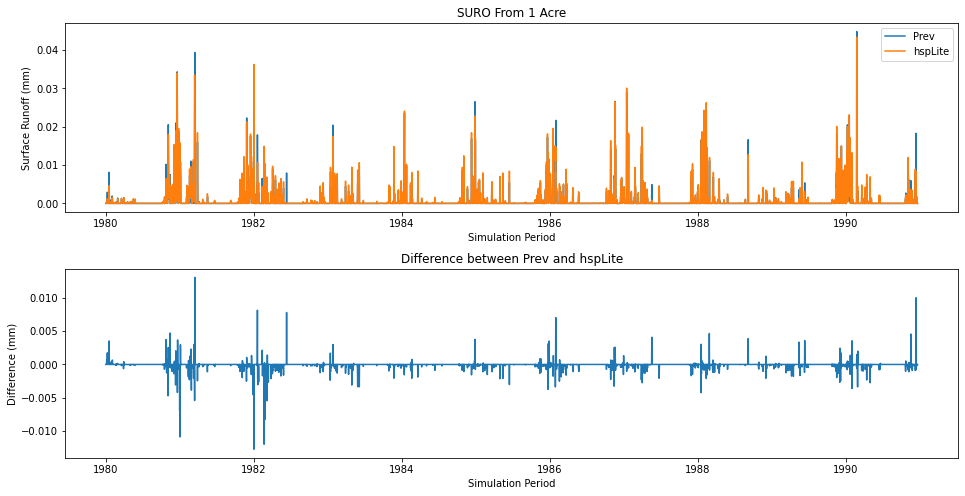

In [172]:
fig = plt.figure(figsize = (16,8))
ax = fig.add_subplot(211)
ax.plot(compare_df[prev_hru+'_mm'], label = 'Prev')
ax.plot(compare_df[new_hru+'_mm'], label = 'hspLite')
ax.legend()
ax.set_xlabel('Simulation Period')
ax.set_ylabel('Surface Runoff (mm)')
ax.set_title('SURO From 1 Acre')

ax2 = fig.add_subplot(212)
ax2.plot(compare_df['Diff'])
ax2.set_xlabel('Simulation Period')
ax2.set_ylabel('Difference (mm)')
ax2.set_title('Difference between Prev and hspLite')

fig.subplots_adjust(hspace = 0.3)
fig.savefig('timeseries\compare_to_prev\SURO_'+prev_hru+'_'+new_hru+'_Comparison_wwhmEvap.png')